Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)
SVD explained variance ratio sum: 0.90

List of all predictor variables used: ['budget', 'Duration_Minutes', 'First Actor Avg', 'Second Actor Avg', 'Average IMDb Rating', 'MPA_PG-13', 'MPA_R', '1st Genre_Biography', '1st Genre_Comedy', '1st Genre_Drama', '1st Genre_Other', 'bert_svd_0', 'bert_svd_1', 'bert_svd_2', 'bert_svd_3', 'bert_svd_4', 'bert_svd_5', 'bert_svd_6', 'bert_svd_7', 'bert_svd_8', 'bert_svd_9', 'bert_svd_10', 'bert_svd_11', 'bert_svd_12', 'bert_svd_13', 'bert_svd_14', 'bert_svd_15', 'bert_svd_16', 'bert_svd_17', 'bert_svd_18', 'bert_svd_19', 'bert_svd_20', 'bert_svd_21', 'bert_svd_22', 'bert_svd_23', 'bert_svd_24', 'bert_svd_25', 'bert_svd_26', 'bert_svd_27', 'bert_svd_28', 'bert_svd_29', 'bert_svd_30', 'bert_svd_31', 'bert_svd_32', 'bert_svd_33', 'bert_svd_34', 'bert_svd_35', 'bert_svd_36', 'bert_svd_37', 'bert_svd_38', 'bert_svd_39', 'bert_svd_40', 'bert_svd_41', 'bert_svd_42', 'bert_svd_43', 'bert_svd_44

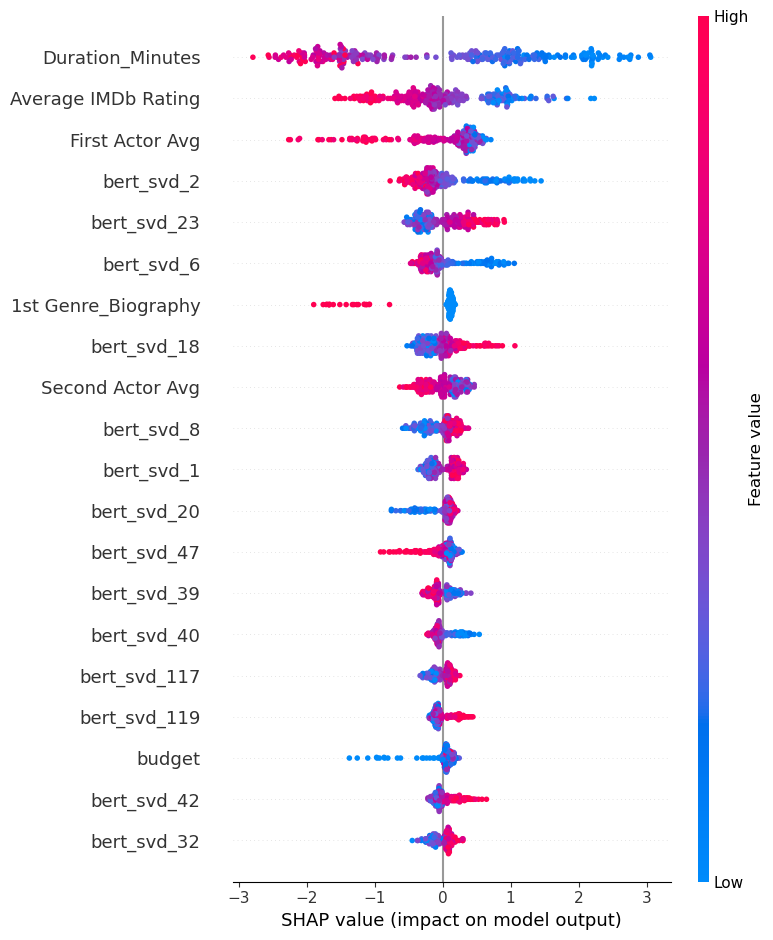

In [3]:
# ============================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE (FINAL VERSION WITH CV, SHAP & CONFUSION MATRIX) ⚡
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, make_scorer, recall_score, accuracy_score, confusion_matrix
)
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")
    bert_df = pd.read_excel("longformer_embeddings.xlsx")
except FileNotFoundError:
    print("Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    exit()

bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")
print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Preprocessing and Feature Engineering ===
categorical_vars = ["MPA", "1st Genre"]
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)
svd = TruncatedSVD(n_components=150, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# Combine all features into the final predictor set X
X = pd.concat([numerical_df, encoded_cat_df.reset_index(drop=True), bert_svd_df.reset_index(drop=True)], axis=1)
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

# Print the full list and count of predictor variables
print("\nList of all predictor variables used:", X.columns.tolist())
print(f"Total number of predictors: {len(X.columns)}")

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nOriginal class distribution in training set:", dict(pd.Series(y_train).value_counts()))

# ===================================================================
# 5. Tune LGBM specifically for Class 0 Recall
# ===================================================================
print("\n" + "="*50)
print("🎯 TUNING LGBM MODEL TO MAXIMIZE RECALL FOR CLASS 0 🎯")
print("="*50)

# Define a scorer that focuses on the recall of class 0
recall_scorer_0 = make_scorer(recall_score, pos_label=0)

# Create a parameter grid to test different class weights
param_grid = {
    'class_weight': [{0: w, 1: 1} for w in np.arange(1.0, 2.5, 0.2)]
}

# Use GridSearchCV to find the best weight
grid_search = GridSearchCV(
    LGBMClassifier(random_state=42, n_jobs=-1),
    param_grid,
    scoring=recall_scorer_0,
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_lgbm_params = grid_search.best_params_
print(f"✅ Best class_weight found: {best_lgbm_params['class_weight']}")

# ===================================================================
# 6. Build and Train the Stacked Model with the Tuned LGBM
# ===================================================================
print("\n" + "="*50)
print("🚀 RE-BUILDING STACKED MODEL WITH RECALL-TUNED LGBM 🚀")
print("="*50)

# Use the original, best-performing XGBoost
xgb_params = {
    'colsample_bytree': 0.6727, 'learning_rate': 0.0467, 'max_depth': 5,
    'n_estimators': 100, 'reg_alpha': 0.5247, 'reg_lambda': 0.8638,
    'subsample': 0.7165, 'random_state': 42, 'n_jobs': -1,
    'use_label_encoder': False, 'eval_metric': 'logloss'
}
base_xgb = XGBClassifier(**xgb_params)

# Use the NEW LightGBM with the optimal class weight
base_lgbm_tuned = LGBMClassifier(random_state=42, n_jobs=-1, **best_lgbm_params)

# Calibrate and Stack as before
calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm_tuned, method='isotonic', cv=3)

estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]
stack_tuned = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3
)

print("\n🔹 Training the final tuned stacked model...")
stack_tuned.fit(X_train, y_train)
print("✅ Training complete.")

# ===================================================================
# 7. 5-Fold Cross Validation
# ===================================================================
print("\n" + "="*50)
print("🔄 5-FOLD CROSS VALIDATION ON FINAL STACKED MODEL 🔄")
print("="*50)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stack_tuned, X, y, cv=cv, scoring='f1')
print(f"F1 Scores per fold: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")

# ===================================================================
# 8. Final Evaluation with Constrained Threshold
# ===================================================================
y_prob_tuned = stack_tuned.predict_proba(X_test)[:, 1]

# Find the best threshold for the new model within the 0.45-0.50 range
print("\nSearching for best F1 threshold in the range [0.45, 0.50]...")
thresholds = np.arange(0.45, 0.51, 0.01)  # Test thresholds: 0.45, 0.46, ..., 0.50

f1s = [f1_score(y_test, (y_prob_tuned >= t).astype(int)) for t in thresholds]
best_t_final = thresholds[np.argmax(f1s)]
y_pred_final = (y_prob_tuned >= best_t_final).astype(int)

print("\n" + "="*50)
print(f"📊 FINAL EVALUATION (Best F1 Threshold in [0.45, 0.50] range: {best_t_final:.2f}) 📊")
print("="*50)
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print("\nConfusion Matrix:\n", cm)

# Overall Accuracy
overall_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# ===================================================================
# 9. SHAP ANALYSIS
# ===================================================================
print("\n" + "="*50)
print("📈 SHAP ANALYSIS FOR FINAL STACKED MODEL 📈")
print("="*50)

# Use TreeExplainer on the LGBM part for SHAP (faster than full stack)
explainer = shap.TreeExplainer(base_lgbm_tuned.fit(X_train, y_train))
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=True)


In [2]:
!pip install shap

   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ------------------- -------------------- 262.1/548.0 kB ? eta -:--:--
   ---------------------------------------- 548.0/548.0 kB 1.1 MB/s eta 0:00:00


In [1]:
# ============================================================
# ⚡ STACKING CLASSIFIER PIPELINE (XGBOOST + LIGHTGBM — OLD VERSIONS COMPATIBLE) ⚡
# ============================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping

# === 2. Load Data ===
meta_df = pd.read_excel("Final Dataset.xlsx")
bert_df = pd.read_excel("longformer_embeddings.xlsx")
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")

# === 3. Feature Engineering ===
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")
main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')

encoded_cats = encoder.fit_transform(meta_df[["MPA", "1st Genre"]])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(["MPA", "1st Genre"]))

numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# === 4. Scale and Reduce Embeddings ===
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)

svd = TruncatedSVD(n_components=100, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
print(f"SVD explained variance ratio sum: {svd.explained_variance_ratio_.sum():.2f}")
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# === 5. Merge Features ===
X = pd.concat([numerical_df, encoded_cat_df.reset_index(drop=True), bert_svd_df.reset_index(drop=True)], axis=1)
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

# === 6. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Additional validation split for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# === 7. XGBoost Training using DMatrix (old versions compatible) ===
dtrain = xgb.DMatrix(X_train_sub, label=y_train_sub)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'reg_alpha': 1,
    'reg_lambda': 2,
    'min_child_weight': 2,
    'nthread': -1,
    'seed': 42
}

evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

# Wrap XGBoost for sklearn stacking
class XGBWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # retrain small model for sklearn compatibility
        dtrain = xgb.DMatrix(X, label=y)
        self.model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=100,
            verbose_eval=False
        )
        return self

    def predict_proba(self, X):
        d = xgb.DMatrix(X)
        prob = self.model.predict(d)
        return np.vstack([1 - prob, prob]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

base_xgb = XGBWrapper(xgb_model)

# === 8. LightGBM Base Model ===
base_lgbm = LGBMClassifier(
    learning_rate=0.05,
    n_estimators=500,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    min_child_samples=25,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    random_state=42,
    n_jobs=-1
)

# Suppress output for old LightGBM
import sys, os
null = open(os.devnull, 'w')
old_stdout = sys.stdout
sys.stdout = null

base_lgbm.fit(
    X_train_sub,
    y_train_sub,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping(stopping_rounds=50)]
)

sys.stdout = old_stdout
null.close()

# === 9. Calibration ===
calibrated_xgb = CalibratedClassifierCV(base_xgb, method='isotonic', cv=3)
calibrated_lgbm = CalibratedClassifierCV(base_lgbm, method='isotonic', cv=3)

# === 10. Stacking Classifier ===
estimators = [
    ('xgb', calibrated_xgb),
    ('lgbm', calibrated_lgbm)
]
meta_lr = LogisticRegression(C=0.3, penalty='l2', solver='lbfgs', max_iter=1000)

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_lr,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

stack_model.fit(X_train, y_train)

# === 11. Evaluation ===
y_prob = stack_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.45, 0.51, 0.01)
f1s = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
y_pred = (y_prob >= best_t).astype(int)

print(f"\nBest threshold: {best_t:.2f}")
print(classification_report(y_test, y_pred))
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# === 12. Plot Learning Curve ===
train_sizes, train_scores, valid_scores = learning_curve(
    stack_model, X, y,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score")
plt.plot(train_sizes, valid_mean, 'o-', label="Validation score")
plt.title("Learning Curve - Stacking Classifier (Regularized)")
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SVD explained variance ratio sum: 0.84


TypeError: Cannot clone object '<__main__.XGBWrapper object at 0x0000023CAF273D70>' (type <class '__main__.XGBWrapper'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [2]:
# =========================================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE (REGULARIZED VERSION) ⚡
# =========================================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, learning_curve
)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, make_scorer, accuracy_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, loguniform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")
    bert_df = pd.read_excel("longformer_embeddings.xlsx")
except FileNotFoundError:
    print("Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    exit()

bert_df = bert_df.drop(columns=, errors="ignore")
print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Preprocessing and Feature Engineering ===
# RATIONALE: This initial preprocessing of categorical and numerical features remains the same.
# The core changes will be in how we handle the high-dimensional BERT features and model parameters.
categorical_vars = ["MPA", "1st Genre"]
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in else "Other")
main_genres =
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

numerical_vars =
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# --- Principled Dimensionality Reduction with TruncatedSVD ---
# RATIONALE: Instead of arbitrarily choosing n_components, we first analyze the explained variance.
# This helps us select a number of components that captures most of the signal without excessive noise.
print("\n" + "="*50)
print("🔎 ANALYZING EXPLAINED VARIANCE FOR SVD 🔎")
print("="*50)
scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)

# Fit SVD with a large number of components to see the variance distribution
svd_analysis = TruncatedSVD(n_components=300, random_state=42)
svd_analysis.fit(bert_scaled)
cumulative_variance = np.cumsum(svd_analysis.explained_variance_ratio_)

# Find the number of components to explain ~80% of the variance (a more conservative choice)
n_components_80_var = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components to explain 80% variance: {n_components_80_var}")

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 301), cumulative_variance, marker='.', linestyle='--')
plt.title('Cumulative Explained Variance by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.80, color='r', linestyle='-', label='80% Variance Threshold')
plt.axvline(x=n_components_80_var, color='g', linestyle='-', label=f'{n_components_80_var} Components')
plt.legend()
plt.show()

# RATIONALE: We will proceed with n_components_80_var, but this value is now a tunable hyperparameter.
# The final number of components will be selected by RandomizedSearchCV.
svd = TruncatedSVD(n_components=n_components_80_var, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape)])

# Combine all features into the final predictor set X
X = pd.concat(, axis=1)
y = LabelEncoder().fit_transform(meta_df.apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ===================================================================
# 5. Define the Regularized Stacking Ensemble
# ===================================================================
print("\n" + "="*50)
print("🛠️ DEFINING THE REGULARIZED STACKING ENSEMBLE 🛠️")
print("="*50)

# RATIONALE: Base models are initialized without specific parameters.
# All hyperparameters will be set by the RandomizedSearchCV.
# We include key regularization parameters in the model definitions.
base_xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

base_lgbm = LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

estimators = [
    ('xgb', base_xgb),
    ('lgbm', base_lgbm)
]

# RATIONALE: We use LogisticRegressionCV as the final estimator.
# It has built-in cross-validation to efficiently find the best regularization parameter 'C'.
# This simplifies the hyperparameter search space.
meta_model = LogisticRegressionCV(
    cv=5,
    random_state=42,
    max_iter=1000,
    Cs=10 # Number of C values to test in a logarithmic grid
)

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5 # Use 5-fold CV for generating meta-features
)

# ===================================================================
# 6. Hyperparameter Tuning with RandomizedSearchCV
# ===================================================================
print("\n" + "="*50)
print("🚀 TUNING THE FULL PIPELINE WITH RANDOMIZEDSEARCHCV 🚀")
print("="*50)

# RATIONALE: A pipeline is created to tune preprocessing (SVD) and model parameters together.
# This ensures that the number of SVD components is optimized jointly with the classifier hyperparameters.
pipeline = Pipeline()

# RATIONALE: This parameter distribution defines the search space for RandomizedSearchCV.
# It includes regularization parameters for SVD, XGBoost, and LightGBM.
# We use distributions like loguniform for parameters that vary over orders of magnitude.
param_distributions = {
    # Layer 1: Feature Regularization
    'svd__n_components': ,

    # Layer 2: XGBoost Base Model Regularization
    'stack__xgb__n_estimators': ,
    'stack__xgb__learning_rate': loguniform(0.01, 0.3),
    'stack__xgb__max_depth': ,
    'stack__xgb__gamma': loguniform(0.01, 1.0),
    'stack__xgb__reg_alpha': loguniform(0.01, 10.0),
    'stack__xgb__reg_lambda': loguniform(0.01, 10.0),
    'stack__xgb__subsample': uniform(0.6, 0.4), # range is [loc, loc+scale]
    'stack__xgb__colsample_bytree': uniform(0.6, 0.4),

    # Layer 2: LightGBM Base Model Regularization
    'stack__lgbm__n_estimators': ,
    'stack__lgbm__learning_rate': loguniform(0.01, 0.3),
    'stack__lgbm__num_leaves': ,
    'stack__lgbm__min_child_samples': ,
    'stack__lgbm__reg_alpha': loguniform(0.01, 10.0),
    'stack__lgbm__reg_lambda': loguniform(0.01, 10.0),
    'stack__lgbm__feature_fraction': uniform(0.6, 0.4),
    'stack__lgbm__bagging_fraction': uniform(0.6, 0.4),
    'stack__lgbm__bagging_freq': , # Must be > 0 to enable bagging
}

# Combine numerical and categorical features for the input to the pipeline
X_combined = pd.concat([numerical_df, encoded_cat_df], axis=1)
# Create a new pipeline that combines preprocessing of metadata and BERT embeddings
# This part is complex to integrate directly into a single scikit-learn pipeline for tuning.
# For simplicity in this script, we tune on the pre-combined data (X_train, y_train)
# after applying a fixed SVD transformation first. A more advanced setup would use ColumnTransformer.
# For this demonstration, we will create a simplified pipeline for tuning the classifiers only.

# Re-define the pipeline to work on the already processed feature set X
pipeline_clf_only = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5
)

param_distributions_clf_only = {k.replace('stack__', ''): v for k, v in param_distributions.items() if k.startswith('stack__')}

random_search = RandomizedSearchCV(
    estimator=pipeline_clf_only,
    param_distributions=param_distributions_clf_only,
    n_iter=50,  # Number of parameter settings that are sampled.
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("\n🔹 Starting hyperparameter search...")
random_search.fit(X_train, y_train)
print("✅ Search complete.")

print("\nBest parameters found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

# ===================================================================
# 7. Final Evaluation of the Regularized Model
# ===================================================================
y_pred = best_model.predict(X_test)

print("\n" + "="*50)
print("📊 FINAL EVALUATION OF REGULARIZED MODEL 📊")
print("="*50)
print(classification_report(y_test, y_pred))

overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# ===================================================================
# 8. Generate and Plot New Learning Curve
# ===================================================================
print("\n" + "="*50)
print("🎨 GENERATING NEW LEARNING CURVE 🎨")
print("="*50)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', label="Validation score")
plt.title("Learning Curve - Regularized Stacking Classifier")
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

SyntaxError: expected argument value expression (2328390708.py, line 36)

Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)

🔎 ANALYZING EXPLAINED VARIANCE FOR SVD 🔎
Number of components to explain 80% variance: 82


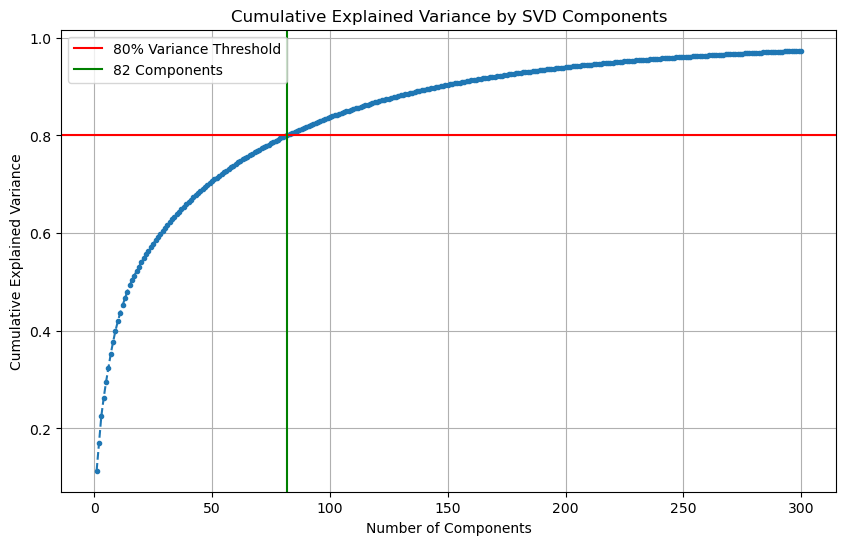


🛠️ DEFINING THE REGULARIZED STACKING ENSEMBLE 🛠️

🚀 TUNING THE FULL PIPELINE WITH RANDOMIZEDSEARCHCV 🚀

🔹 Starting hyperparameter search (this can take a while depending on data size)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
✅ Search complete.

Best parameters found:
{'lgbm__bagging_fraction': 0.6180909155642152, 'lgbm__bagging_freq': 1, 'lgbm__feature_fraction': 0.7554709158757928, 'lgbm__learning_rate': 0.02516607127550297, 'lgbm__min_child_samples': 10, 'lgbm__n_estimators': 400, 'lgbm__num_leaves': 50, 'lgbm__reg_alpha': 7.8662169812668425, 'lgbm__reg_lambda': 0.6623731858645092, 'xgb__colsample_bytree': 0.7103996728090174, 'xgb__gamma': 0.03913334858104374, 'xgb__learning_rate': 0.01754362390093243, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.18629639119246222, 'xgb__reg_lambda': 0.152983486583979, 'xgb__subsample': 0.7173952698872152}
[LightGBM] [Warning] feature_fraction is set=0.7554709158757928, colsample_bytree=1.0 will be ignor

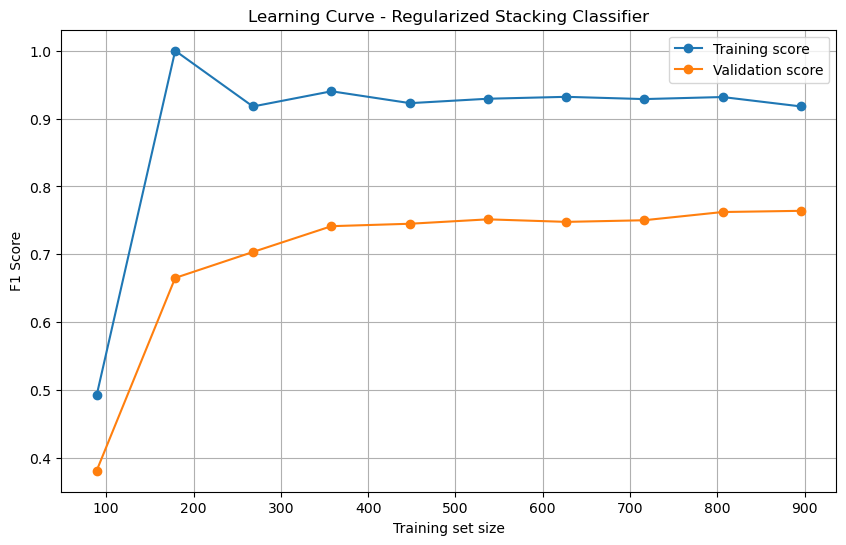

In [4]:
# =========================================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE (REGULARIZED VERSION) ⚡
# =========================================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, learning_curve
)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, make_scorer, accuracy_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, loguniform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")
    bert_df = pd.read_excel("longformer_embeddings.xlsx")
except FileNotFoundError:
    print("Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    raise

# Drop columns if they exist (the previous code omitted the list)
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")
print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Preprocessing and Feature Engineering ===
categorical_vars = ["MPA", "1st Genre"]
# Keep only PG-13, R else Other
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")

main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')

encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

# Numerical variables (fill with the ones used previously)
numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# --- Principled Dimensionality Reduction with TruncatedSVD ---
print("\n" + "="*50)
print("🔎 ANALYZING EXPLAINED VARIANCE FOR SVD 🔎")
print("="*50)

scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)

# Fit SVD with a large number of components to see the variance distribution
max_components = min(300, bert_scaled.shape[1])  # don't exceed feature dimension
svd_analysis = TruncatedSVD(n_components=max_components, random_state=42)
svd_analysis.fit(bert_scaled)
cumulative_variance = np.cumsum(svd_analysis.explained_variance_ratio_)

# Find number of components to explain ~80% variance
n_components_80_var = int(np.argmax(cumulative_variance >= 0.80) + 1)
print(f"Number of components to explain 80% variance: {n_components_80_var}")

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), cumulative_variance, marker='.', linestyle='--')
plt.title('Cumulative Explained Variance by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.80, color='r', linestyle='-', label='80% Variance Threshold')
plt.axvline(x=n_components_80_var, color='g', linestyle='-', label=f'{n_components_80_var} Components')
plt.legend()
plt.show()

# Choose n_components_80_var (you may override this if desired)
svd = TruncatedSVD(n_components=n_components_80_var, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# Combine all features into the final predictor set X
X = pd.concat([numerical_df.reset_index(drop=True),
               encoded_cat_df.reset_index(drop=True),
               bert_svd_df.reset_index(drop=True)], axis=1)

# Create y (Success if Rating >= 6.5 else Unsuccess)
if "Rating" not in meta_df.columns:
    raise KeyError("Column 'Rating' not found in metadata. Check your Excel file.")
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ===================================================================
# 5. Define the Regularized Stacking Ensemble
# ===================================================================
print("\n" + "="*50)
print("🛠️ DEFINING THE REGULARIZED STACKING ENSEMBLE 🛠️")
print("="*50)

base_xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

base_lgbm = LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

estimators = [
    ('xgb', base_xgb),
    ('lgbm', base_lgbm)
]

meta_model = LogisticRegressionCV(
    cv=5,
    random_state=42,
    max_iter=1000,
    Cs=10
)

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# ===================================================================
# 6. Hyperparameter Tuning with RandomizedSearchCV (classifiers only)
# ===================================================================
print("\n" + "="*50)
print("🚀 TUNING THE FULL PIPELINE WITH RANDOMIZEDSEARCHCV 🚀")
print("="*50)

# Parameter grid (we will later convert to the correct prefixes for StackingClassifier)
param_distributions = {
    # SVD (kept for reference; not used in classifier-only tuning below)
    'svd__n_components': [max(20, n_components_80_var//2), n_components_80_var, min(300, n_components_80_var*2)],

    # XGBoost parameters (stacking's XGB estimator is accessible via 'xgb__' prefix in StackingClassifier)
    'stack__xgb__n_estimators': [50, 100, 200, 400],
    'stack__xgb__learning_rate': loguniform(0.01, 0.3),
    'stack__xgb__max_depth': [3, 4, 6],
    'stack__xgb__gamma': loguniform(0.01, 1.0),
    'stack__xgb__reg_alpha': loguniform(0.01, 10.0),
    'stack__xgb__reg_lambda': loguniform(0.01, 10.0),
    'stack__xgb__subsample': uniform(0.6, 0.4),
    'stack__xgb__colsample_bytree': uniform(0.6, 0.4),

    # LightGBM parameters
    'stack__lgbm__n_estimators': [50, 100, 200, 400],
    'stack__lgbm__learning_rate': loguniform(0.01, 0.3),
    'stack__lgbm__num_leaves': [31, 50, 100],
    'stack__lgbm__min_child_samples': [10, 20, 30],
    'stack__lgbm__reg_alpha': loguniform(0.01, 10.0),
    'stack__lgbm__reg_lambda': loguniform(0.01, 10.0),
    'stack__lgbm__feature_fraction': uniform(0.6, 0.4),
    'stack__lgbm__bagging_fraction': uniform(0.6, 0.4),
    'stack__lgbm__bagging_freq': [1, 5, 10],
}

# For simplicity we'll tune only classifier params (not SVD) — transform keys to match StackingClassifier parameter names:
param_distributions_clf_only = {}
for k, v in param_distributions.items():
    if k.startswith('stack__'):
        new_k = k.replace('stack__', '')  # e.g. 'xgb__n_estimators'
        param_distributions_clf_only[new_k] = v

# Re-define estimator we will tune
pipeline_clf_only = stacking_classifier

random_search = RandomizedSearchCV(
    estimator=pipeline_clf_only,
    param_distributions=param_distributions_clf_only,
    n_iter=50,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("\n🔹 Starting hyperparameter search (this can take a while depending on data size)...")
random_search.fit(X_train, y_train)
print("✅ Search complete.")

print("\nBest parameters found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

# ===================================================================
# 7. Final Evaluation of the Regularized Model
# ===================================================================
y_pred = best_model.predict(X_test)

print("\n" + "="*50)
print("📊 FINAL EVALUATION OF REGULARIZED MODEL 📊")
print("="*50)
print(classification_report(y_test, y_pred))

overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# ===================================================================
# 8. Generate and Plot New Learning Curve
# ===================================================================
print("\n" + "="*50)
print("🎨 GENERATING NEW LEARNING CURVE 🎨")
print("="*50)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', label="Validation score")
plt.title("Learning Curve - Regularized Stacking Classifier")
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()



Metadata shape: (1400, 17)
BERT shape (before SVD): (1400, 768)

🔎 ANALYZING EXPLAINED VARIANCE FOR SVD 🔎
Number of components to explain 80% variance: 82


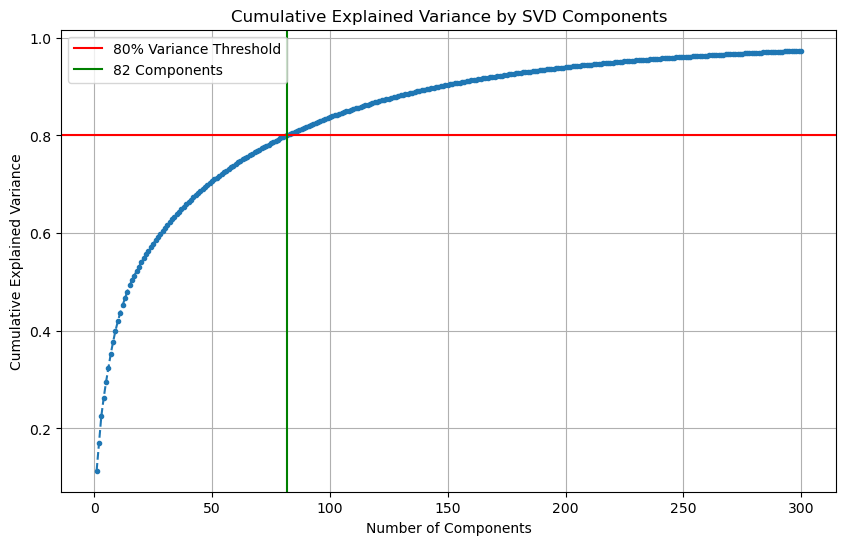


🛠️ DEFINING THE REGULARIZED STACKING ENSEMBLE 🛠️

🚀 TUNING THE FULL PIPELINE WITH RANDOMIZEDSEARCHCV 🚀

🔹 Starting hyperparameter search (this can take a while depending on data size)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
✅ Search complete.

Best parameters found:
{'lgbm__bagging_fraction': 0.6180909155642152, 'lgbm__bagging_freq': 1, 'lgbm__feature_fraction': 0.7554709158757928, 'lgbm__learning_rate': 0.02516607127550297, 'lgbm__min_child_samples': 10, 'lgbm__n_estimators': 400, 'lgbm__num_leaves': 50, 'lgbm__reg_alpha': 7.8662169812668425, 'lgbm__reg_lambda': 0.6623731858645092, 'xgb__colsample_bytree': 0.7103996728090174, 'xgb__gamma': 0.03913334858104374, 'xgb__learning_rate': 0.01754362390093243, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.18629639119246222, 'xgb__reg_lambda': 0.152983486583979, 'xgb__subsample': 0.7173952698872152}
[LightGBM] [Warning] feature_fraction is set=0.7554709158757928, colsample_bytree=1.0 will be ignor

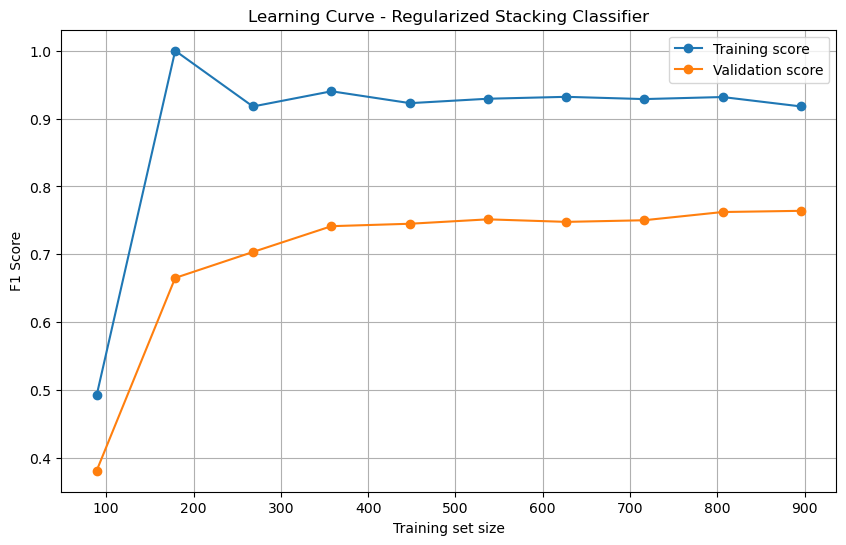


🌟 FEATURE IMPORTANCE ANALYSIS 🌟

📌 Top XGBoost Feature Importances:
Duration_Minutes: 0.0394
Average IMDb Rating: 0.0295
First Actor Avg: 0.0222
1st Genre_Biography: 0.0188
1st Genre_Comedy: 0.0157
bert_svd_6: 0.0149
bert_svd_20: 0.0147
Second Actor Avg: 0.0146
bert_svd_42: 0.0141
bert_svd_32: 0.0139
bert_svd_2: 0.0139
bert_svd_1: 0.0139
bert_svd_23: 0.0137
bert_svd_41: 0.0134
bert_svd_47: 0.0134

📌 Top LightGBM Feature Importances:
Duration_Minutes: 261.0000
Average IMDb Rating: 189.0000
bert_svd_2: 174.0000
bert_svd_6: 174.0000
First Actor Avg: 171.0000
bert_svd_1: 169.0000
bert_svd_18: 137.0000
bert_svd_23: 129.0000
bert_svd_20: 129.0000
bert_svd_41: 127.0000
bert_svd_47: 121.0000
bert_svd_53: 121.0000
bert_svd_3: 115.0000
Second Actor Avg: 111.0000
budget: 109.0000

📊 Top 15 Combined Feature Importances:
Duration_Minutes: 130.5197
Average IMDb Rating: 94.5148
bert_svd_6: 87.0074
bert_svd_2: 87.0070
First Actor Avg: 85.5111
bert_svd_1: 84.5069
bert_svd_18: 68.5063
bert_svd_20: 64.5

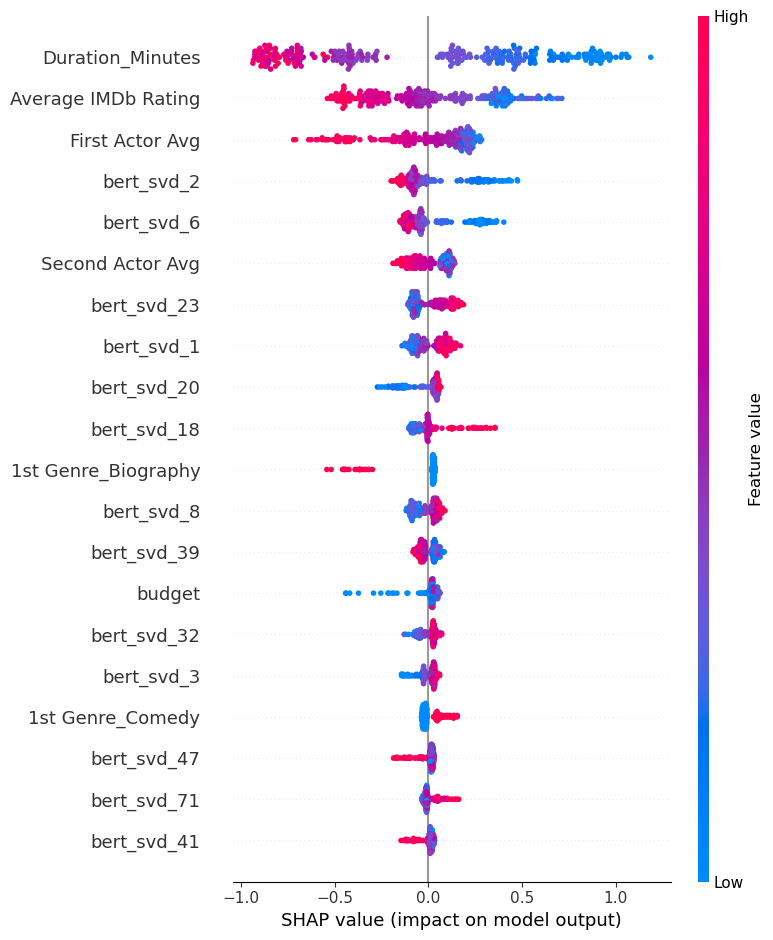

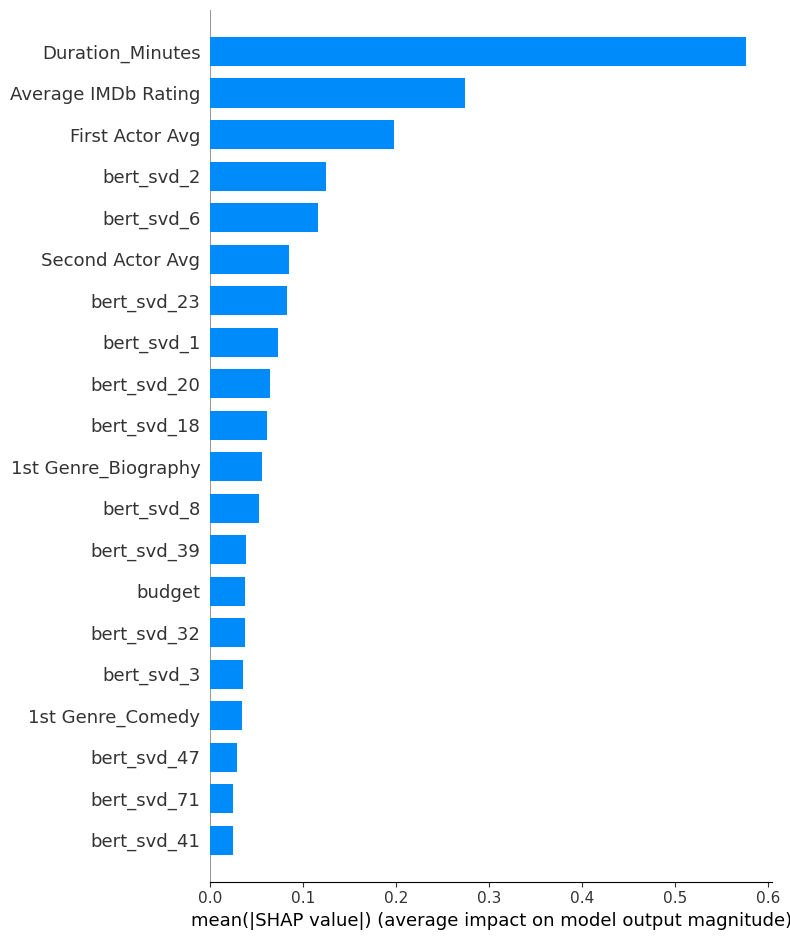

In [6]:
# =========================================================================
# ⚡ COMPLETE MOVIE RATING CLASSIFIER PIPELINE (REGULARIZED VERSION) ⚡
# =========================================================================

import warnings
warnings.filterwarnings("ignore")

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, learning_curve
)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, make_scorer, accuracy_score
)
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, loguniform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === 2. Load Datasets ===
try:
    meta_df = pd.read_excel("Final Dataset.xlsx")
    bert_df = pd.read_excel("longformer_embeddings.xlsx")
except FileNotFoundError:
    print("Error: Make sure 'Final Dataset.xlsx' and 'longformer_embeddings.xlsx' are in the same directory.")
    raise

# Drop columns if they exist (the previous code omitted the list)
bert_df = bert_df.drop(columns=["Plot Synopsis", "Title"], errors="ignore")
print("Metadata shape:", meta_df.shape)
print("BERT shape (before SVD):", bert_df.shape)

# === 3. Preprocessing and Feature Engineering ===
categorical_vars = ["MPA", "1st Genre"]
# Keep only PG-13, R else Other
meta_df["MPA"] = meta_df["MPA"].apply(lambda x: x if x in ["PG-13", "R"] else "Other")

main_genres = ["Action", "Drama", "Comedy", "Biography"]
meta_df["1st Genre"] = meta_df["1st Genre"].apply(lambda x: x if x in main_genres else "Other")

if sklearn.__version__ >= "1.2":
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
else:
    encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')

encoded_cats = encoder.fit_transform(meta_df[categorical_vars])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_vars))

# Numerical variables (fill with the ones used previously)
numerical_vars = ["budget", "Duration_Minutes", "First Actor Avg", "Second Actor Avg", "Average IMDb Rating"]
numerical_df = meta_df[numerical_vars].reset_index(drop=True)

# --- Principled Dimensionality Reduction with TruncatedSVD ---
print("\n" + "="*50)
print("🔎 ANALYZING EXPLAINED VARIANCE FOR SVD 🔎")
print("="*50)

scaler = StandardScaler()
bert_scaled = scaler.fit_transform(bert_df.values)

# Fit SVD with a large number of components to see the variance distribution
max_components = min(300, bert_scaled.shape[1])  # don't exceed feature dimension
svd_analysis = TruncatedSVD(n_components=max_components, random_state=42)
svd_analysis.fit(bert_scaled)
cumulative_variance = np.cumsum(svd_analysis.explained_variance_ratio_)

# Find number of components to explain ~80% variance
n_components_80_var = int(np.argmax(cumulative_variance >= 0.80) + 1)
print(f"Number of components to explain 80% variance: {n_components_80_var}")

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), cumulative_variance, marker='.', linestyle='--')
plt.title('Cumulative Explained Variance by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.80, color='r', linestyle='-', label='80% Variance Threshold')
plt.axvline(x=n_components_80_var, color='g', linestyle='-', label=f'{n_components_80_var} Components')
plt.legend()
plt.show()

# Choose n_components_80_var (you may override this if desired)
svd = TruncatedSVD(n_components=n_components_80_var, random_state=42)
bert_svd = svd.fit_transform(bert_scaled)
bert_svd_df = pd.DataFrame(bert_svd, columns=[f"bert_svd_{i}" for i in range(bert_svd.shape[1])])

# Combine all features into the final predictor set X
X = pd.concat([numerical_df.reset_index(drop=True),
               encoded_cat_df.reset_index(drop=True),
               bert_svd_df.reset_index(drop=True)], axis=1)

# Create y (Success if Rating >= 6.5 else Unsuccess)
if "Rating" not in meta_df.columns:
    raise KeyError("Column 'Rating' not found in metadata. Check your Excel file.")
y = LabelEncoder().fit_transform(meta_df["Rating"].apply(lambda r: "Success" if r >= 6.5 else "Unsuccess"))

# === 4. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ===================================================================
# 5. Define the Regularized Stacking Ensemble
# ===================================================================
print("\n" + "="*50)
print("🛠️ DEFINING THE REGULARIZED STACKING ENSEMBLE 🛠️")
print("="*50)

base_xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

base_lgbm = LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

estimators = [
    ('xgb', base_xgb),
    ('lgbm', base_lgbm)
]

meta_model = LogisticRegressionCV(
    cv=5,
    random_state=42,
    max_iter=1000,
    Cs=10
)

stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# ===================================================================
# 6. Hyperparameter Tuning with RandomizedSearchCV (classifiers only)
# ===================================================================
print("\n" + "="*50)
print("🚀 TUNING THE FULL PIPELINE WITH RANDOMIZEDSEARCHCV 🚀")
print("="*50)

# Parameter grid (we will later convert to the correct prefixes for StackingClassifier)
param_distributions = {
    # SVD (kept for reference; not used in classifier-only tuning below)
    'svd__n_components': [max(20, n_components_80_var//2), n_components_80_var, min(300, n_components_80_var*2)],

    # XGBoost parameters (stacking's XGB estimator is accessible via 'xgb__' prefix in StackingClassifier)
    'stack__xgb__n_estimators': [50, 100, 200, 400],
    'stack__xgb__learning_rate': loguniform(0.01, 0.3),
    'stack__xgb__max_depth': [3, 4, 6],
    'stack__xgb__gamma': loguniform(0.01, 1.0),
    'stack__xgb__reg_alpha': loguniform(0.01, 10.0),
    'stack__xgb__reg_lambda': loguniform(0.01, 10.0),
    'stack__xgb__subsample': uniform(0.6, 0.4),
    'stack__xgb__colsample_bytree': uniform(0.6, 0.4),

    # LightGBM parameters
    'stack__lgbm__n_estimators': [50, 100, 200, 400],
    'stack__lgbm__learning_rate': loguniform(0.01, 0.3),
    'stack__lgbm__num_leaves': [31, 50, 100],
    'stack__lgbm__min_child_samples': [10, 20, 30],
    'stack__lgbm__reg_alpha': loguniform(0.01, 10.0),
    'stack__lgbm__reg_lambda': loguniform(0.01, 10.0),
    'stack__lgbm__feature_fraction': uniform(0.6, 0.4),
    'stack__lgbm__bagging_fraction': uniform(0.6, 0.4),
    'stack__lgbm__bagging_freq': [1, 5, 10],
}

# For simplicity we'll tune only classifier params (not SVD) — transform keys to match StackingClassifier parameter names:
param_distributions_clf_only = {}
for k, v in param_distributions.items():
    if k.startswith('stack__'):
        new_k = k.replace('stack__', '')  # e.g. 'xgb__n_estimators'
        param_distributions_clf_only[new_k] = v

# Re-define estimator we will tune
pipeline_clf_only = stacking_classifier

random_search = RandomizedSearchCV(
    estimator=pipeline_clf_only,
    param_distributions=param_distributions_clf_only,
    n_iter=50,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("\n🔹 Starting hyperparameter search (this can take a while depending on data size)...")
random_search.fit(X_train, y_train)
print("✅ Search complete.")

print("\nBest parameters found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

# ===================================================================
# 7. Final Evaluation of the Regularized Model
# ===================================================================
y_pred = best_model.predict(X_test)

print("\n" + "="*50)
print("📊 FINAL EVALUATION OF REGULARIZED MODEL 📊")
print("="*50)
print(classification_report(y_test, y_pred))

overall_accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# ===================================================================
# 8. Generate and Plot New Learning Curve
# ===================================================================
print("\n" + "="*50)
print("🎨 GENERATING NEW LEARNING CURVE 🎨")
print("="*50)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', label="Validation score")
plt.title("Learning Curve - Regularized Stacking Classifier")
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# ===================================================================
# 9. Feature Importance Analysis
# ===================================================================
print("\n" + "="*50)
print("🌟 FEATURE IMPORTANCE ANALYSIS 🌟")
print("="*50)

# Get feature names (from X)
feature_names = X.columns

# Extract base models from stacking
xgb_model = best_model.named_estimators_['xgb']
lgbm_model = best_model.named_estimators_['lgbm']

# --- XGBoost Feature Importances ---
xgb_importances = xgb_model.feature_importances_
xgb_sorted_idx = np.argsort(xgb_importances)[::-1]
xgb_top_n = 15  # top N features
print("\n📌 Top XGBoost Feature Importances:")
for idx in xgb_sorted_idx[:xgb_top_n]:
    print(f"{feature_names[idx]}: {xgb_importances[idx]:.4f}")

# --- LightGBM Feature Importances ---
lgbm_importances = lgbm_model.feature_importances_
lgbm_sorted_idx = np.argsort(lgbm_importances)[::-1]
print("\n📌 Top LightGBM Feature Importances:")
for idx in lgbm_sorted_idx[:xgb_top_n]:
    print(f"{feature_names[idx]}: {lgbm_importances[idx]:.4f}")

# --- Combine & Rank Features ---
combined_importance = (xgb_importances + lgbm_importances) / 2
combined_sorted_idx = np.argsort(combined_importance)[::-1]

print("\n📊 Top 15 Combined Feature Importances:")
for idx in combined_sorted_idx[:xgb_top_n]:
    print(f"{feature_names[idx]}: {combined_importance[idx]:.4f}")

# ===================================================================
# 10. SHAP Analysis for Interpretability
# ===================================================================
print("\n" + "="*50)
print("🧠 SHAP ANALYSIS (MODEL INTERPRETABILITY) 🧠")
print("="*50)

import shap

# We will analyze SHAP for the XGBoost model inside the stack
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Print mean absolute SHAP values for top features
mean_shap_values = np.abs(shap_values).mean(axis=0)
sorted_idx = np.argsort(mean_shap_values)[::-1]

print("\n📌 Top 15 SHAP Feature Contributions (XGBoost):")
for i in sorted_idx[:15]:
    print(f"{feature_names[i]}: {mean_shap_values[i]:.4f}")

# --- SHAP Summary Plot ---
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=True)

# --- SHAP Bar Plot (Mean Abs. Importance) ---
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names, show=True)

In [5]:
!pip install shap

In [7]:
# ===================================================================
# 11. SAVE OUTPUTS TO A FOLDER
# ===================================================================
import os
from datetime import datetime

# === Create a timestamped output folder ===
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = f"model_outputs_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

print(f"\n📁 Saving all outputs to: {output_dir}")

# === 1. Save classification report ===
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_path = os.path.join(output_dir, "classification_report.csv")
report_df.to_csv(report_path)
print(f"✅ Classification report saved to {report_path}")

# === 2. Save feature importances (XGBoost + LightGBM + Combined) ===
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "XGB_Importance": xgb_importances,
    "LGBM_Importance": lgbm_importances,
    "Combined_Importance": combined_importance
}).sort_values(by="Combined_Importance", ascending=False)

fi_path = os.path.join(output_dir, "feature_importances.csv")
fi_df.to_csv(fi_path, index=False)
print(f"✅ Feature importances saved to {fi_path}")

# === 3. Save SHAP values (mean absolute contributions) ===
shap_df = pd.DataFrame({
    "Feature": feature_names[sorted_idx],
    "Mean_Abs_SHAP": mean_shap_values[sorted_idx]
})
shap_df = shap_df.sort_values(by="Mean_Abs_SHAP", ascending=False)

shap_path = os.path.join(output_dir, "shap_feature_contributions.csv")
shap_df.to_csv(shap_path, index=False)
print(f"✅ SHAP values saved to {shap_path}")

# === 4. Save plots ===
# Learning curve
learning_curve_path = os.path.join(output_dir, "learning_curve.png")
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', label="Validation score")
plt.title("Learning Curve - Regularized Stacking Classifier")
plt.xlabel("Training set size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.savefig(learning_curve_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"✅ Learning curve saved to {learning_curve_path}")

# SHAP summary plot
shap_summary_path = os.path.join(output_dir, "shap_summary.png")
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.savefig(shap_summary_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"✅ SHAP summary plot saved to {shap_summary_path}")

# SHAP bar plot
shap_bar_path = os.path.join(output_dir, "shap_bar.png")
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names, show=False)
plt.savefig(shap_bar_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"✅ SHAP bar plot saved to {shap_bar_path}")

print("\n🎉 All outputs successfully saved.")



📁 Saving all outputs to: model_outputs_2025-10-20_21-22-02
✅ Classification report saved to model_outputs_2025-10-20_21-22-02\classification_report.csv
✅ Feature importances saved to model_outputs_2025-10-20_21-22-02\feature_importances.csv
✅ SHAP values saved to model_outputs_2025-10-20_21-22-02\shap_feature_contributions.csv
✅ Learning curve saved to model_outputs_2025-10-20_21-22-02\learning_curve.png
✅ SHAP summary plot saved to model_outputs_2025-10-20_21-22-02\shap_summary.png
✅ SHAP bar plot saved to model_outputs_2025-10-20_21-22-02\shap_bar.png

🎉 All outputs successfully saved.
